In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import pandas as pd

from astropy.time import Time
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits

from scipy.linalg import lstsq
from scipy.optimize import curve_fit

import lightkurve as lk
import tessreduce as tr

import pickle

c:\Users\vishn\miniconda3\envs\SPT_Flares\lib\site-packages\lightkurve\config\__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to C:\Users\vishn\.lightkurve\cache. Please move all the files in the legacy directory C:\Users\vishn\.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


# Extract TESS Lightcurves

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 29,2020,SPOC,120,207138379,0.0
1,TESS Sector 30,2020,SPOC,120,207138379,0.0
2,TESS Sector 30,2020,TESS-SPOC,600,207138379,0.0
3,TESS Sector 29,2020,TESS-SPOC,600,207138379,0.0
4,TESS Sector 29,2020,QLP,600,207138379,0.0
5,TESS Sector 30,2020,QLP,600,207138379,0.0
6,TESS Sector 30,2020,CDIPS,1800,207138379,0.0
7,TESS Sector 29,2020,CDIPS,1800,207138379,0.0


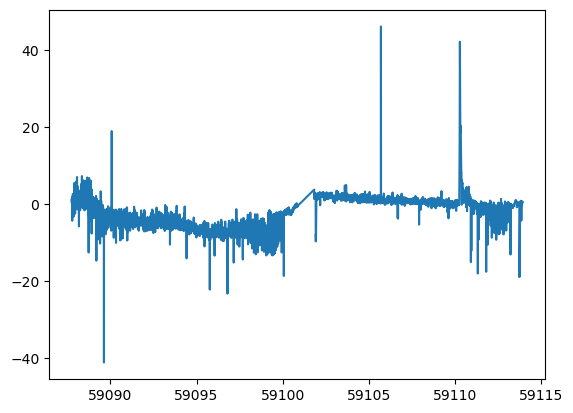

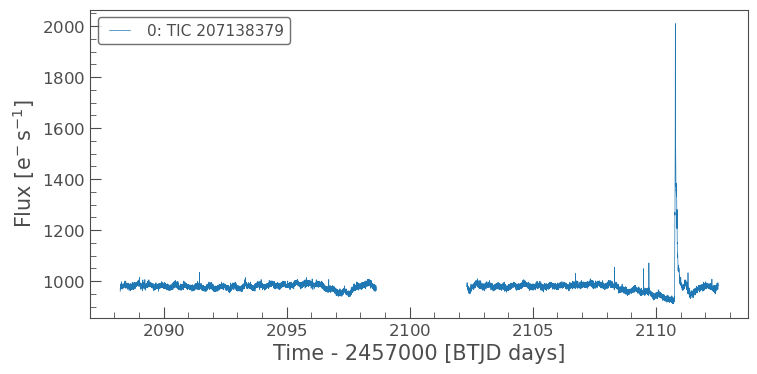

In [5]:
# TESSReduce
dbfile = open(f'TIC207138379_TR_LC', 'rb')
TR_lc = pickle.load(dbfile)
dbfile.close()
plt.plot(TR_lc[0], TR_lc[1])

# Lightkurve Raw TESS
obj = lk.search_lightcurve('TIC207138379', mission= 'TESS')
res_2020 = np.where(obj.table['year'] == 2020)

lightcurves = obj[res_2020][0].download_all()
lightcurves.plot()

obj[res_2020]

# Removing Quiescent Behaviors

## Locating relevant time stamps (fit_start, flare_start). Currently done by hand

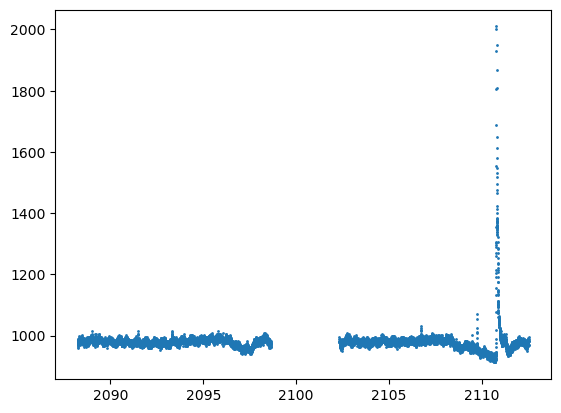

In [6]:
flare_obs = obj[res_2020][0].download()
qual = flare_obs.quality.value
time = np.array(flare_obs.time.value)
time = time[qual ==0]
sap_flux = np.array(flare_obs.pdcsap_flux.value)
sap_flux = sap_flux[qual ==0]
plt.scatter(time,sap_flux, s=1)

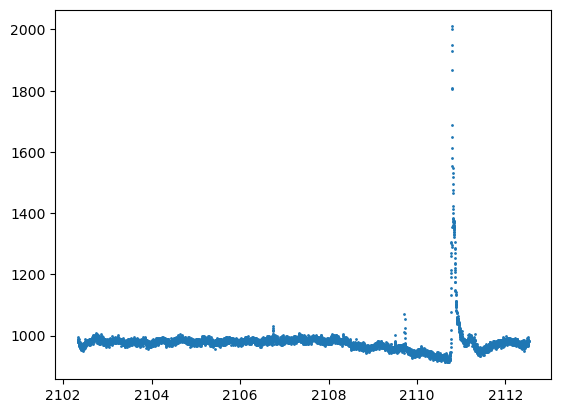

In [7]:
fitint_start = np.where(time>2102.)[0][0]
plt.scatter(time[fitint_start:],sap_flux[fitint_start:], s=1)
time = time[fitint_start:]
sap_flux = sap_flux[fitint_start:]

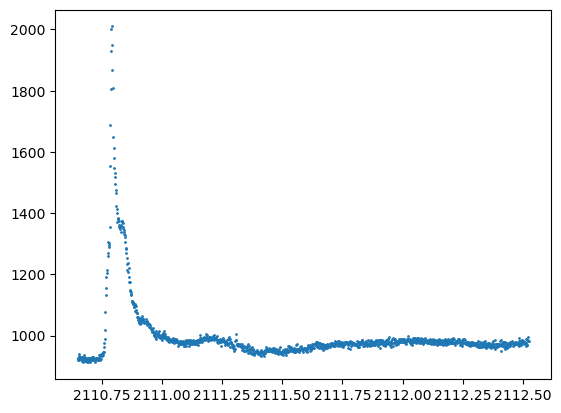

In [10]:
flare_start = np.where(time>2110.65)[0][0]
plt.scatter(time[flare_start:],sap_flux[flare_start:], s=1)

## numpy fft

In [10]:
def fit_with_numpyfft(time, flux, flare_start_idx):
    fit_time = time[:flare_start_idx]
    fit_flux = flux[:flare_start_idx]


    fft_coeffs = np.fft.fft(fit_flux)
    freq = np.fft.fftfreq(len(fit_time), d= (fit_time[1] - fit_time[0]))

    # # restrict terms to those above orbital frequency
    # valid_freq_ids = np.where(np.abs(freq) < 1/porb)[0]
    # print(np.min(1/np.abs(freq[valid_freq_ids])))
    # filtered_fft = np.zeros_like(fft_coeffs)
    # filtered_fft[valid_freq_ids] = fft_coeffs[valid_freq_ids]
    # print(len(freq), len(valid_freq_ids))

    model_flux = np.fft.ifft(fft_coeffs).real

    extrapolated_flux = np.zeros_like(time)
    for i,fr in enumerate(freq):#valid_freq_ids:
        amplitude = np.abs(fft_coeffs[i]) / len(fit_time)
        phase = np.angle(fft_coeffs[i])
        extrapolated_flux += amplitude * np.cos(2 * np.pi * fr * (time - time[0]) + phase)

    return model_flux, extrapolated_flux
    

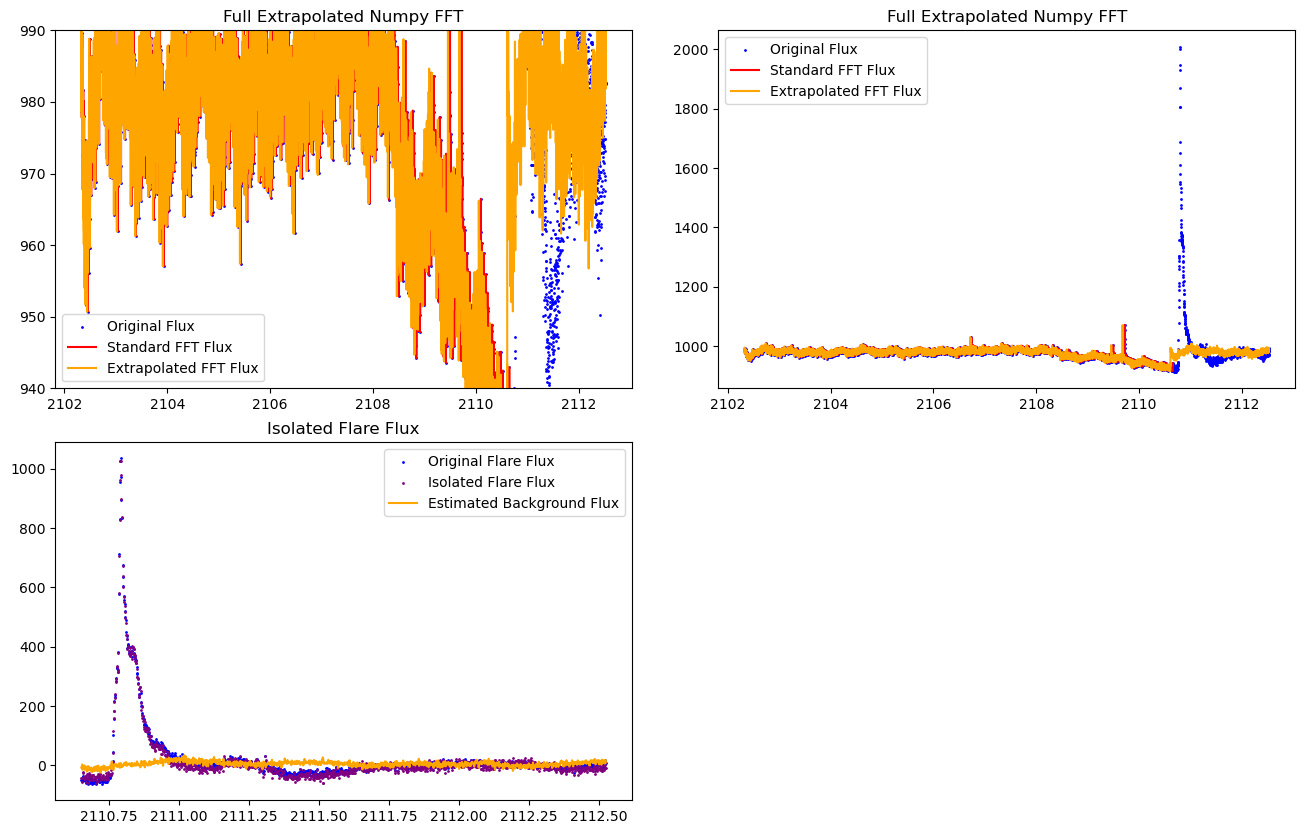

In [11]:
modulations, fitted_modulations = fit_with_numpyfft(time, sap_flux, flare_start)

fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.15, hspace=0.15)

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax1.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax1.legend()
ax1.set_ylim(940,990)
ax1.set_title("Full Extrapolated Numpy FFT")

ax2 = fig.add_subplot(gs[0,1])
ax2.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax2.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax2.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax2.legend()
ax2.set_title("Full Extrapolated Numpy FFT")

ax3 = fig.add_subplot(gs[1,0])
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - np.mean(sap_flux[:flare_start]), s= 1, c= 'b', label= "Original Flare Flux")
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - fitted_modulations[flare_start:], s= 1, c= 'purple', label= "Isolated Flare Flux")
ax3.plot(time[flare_start:], fitted_modulations[flare_start:] - np.mean(sap_flux[:flare_start]), c= 'orange', label= "Estimated Background Flux")
ax3.legend()
ax3.set_title("Isolated Flare Flux")

plt.tight_layout()

## Fit Polynomial

In [ ]:
t = time[500:915] - np.mean(time[500:915])
flux = sap_flux[500:915]
flux_cut = np.where(flux < 974)
t = t[flux_cut]
flux = flux[flux_cut]

order = 12
def nth_order_poly(x, *coeffs):
    result = 0
    for i, c in enumerate(coeffs):
        result += c*x**i
    return result

initial_guess = np.zeros(order+1)
initial_guess[0] = 962.5

popt, pcov = curve_fit(lambda x, *params: nth_order_poly(x, *params), t, flux, p0= initial_guess)
print(popt)

y = lambda x: nth_order_poly(x, *popt)

plt.scatter(t, flux, s=1)
plt.plot(t, y(t))

## Cosine Transform Fit
Fails as cosine basis fit with finite terms will only fit well within fit duration, but we must extrapolate to approximate flux during flare.

In [ ]:
def cosine_transform_fit(time, flux, Porb):
    fit_time = time[:flare_start]
    fit_flux = flux[:flare_start]
    T = fit_time[-1] - fit_time[0]
    N = round((2 * T) / (Porb))
    print(N)

    def cosine_basis(t, i):
        return np.cos((2 * np.pi / (2 * T)) * i * t)
    # Create the design matrix using the cosine basis functions
    A = np.array([cosine_basis(fit_time, i) for i in range(0, N+1)]).T
    # Solve for the linear coefficients using least squares
    coeffs, _, _, _ = lstsq(A, fit_flux)
    # Calculate the model flux
    model_flux = np.dot(A, coeffs)

    A_full = np.array([cosine_basis(time, i) for i in range(0, N+1)]).T
    full_model_flux = np.dot(A_full, coeffs)

    return model_flux, full_model_flux

In [ ]:
modulations, fitted_modulations = cosine_transform_fit(time, sap_flux, porb)

# plt.plot(time[:flare_start], sap_flux[:flare_start], c= 'b', label='original flux')
# plt.plot(time[:flare_start], modulations, c= 'orange', label='modulation')
plt.plot(time, sap_flux, c= 'b', label='original flux')
plt.plot(time, fitted_modulations, c= 'orange', label='fitted flux')
plt.legend()

# Plotting to keep in back pocket

In [ ]:
modulations, fitted_modulations = fit_with_numpyfft(time, sap_flux, flare_start)

fig = plt.figure(figsize= (16,10))
gs = gridspec.GridSpec(2, 2, figure=fig, wspace=0.2, hspace=0.2)

ax1 = fig.add_subplot(gs[0,0])
ax1.scatter(time, sap_flux, s= 1, c= 'b', label='Original Flux')
ax1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT Flux')
ax1.plot(time, fitted_modulations, c= 'orange', label='Extrapolated FFT Flux')
ax1.legend()
ax1.set_ylim(940,990)
ax1.set_title("Full Extrapolated Numpy FFT")


gs_sub = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs[0, 1], wspace=0.4)
d = 0.5
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2_1 = fig.add_subplot(gs_sub[0,0])
ax2_1.scatter(time[:flare_start], sap_flux[:flare_start], s= 1, c= 'b', label='Original flux')
ax2_1.plot(time[:flare_start], modulations, c= 'r', label='Standard FFT')
ax2_1.plot(time[:flare_start], fitted_modulations[:flare_start], c= 'orange', label='Extrapolated FFT')
ax2_1.set_xlim(time[0], time[750])
ax2_1.spines.right.set_visible(False)
ax2_1.yaxis.tick_left()
ax2_1.plot([1, 1], [0, 1], transform=ax2_1.transAxes, **kwargs)

ax2_2 = fig.add_subplot(gs_sub[0,1])
ax2_2.plot(time[:flare_start], sap_flux[:flare_start], c= 'b', label='Original flux')
ax2_2.plot(time[:flare_start], modulations[:flare_start], c= 'r', label='Standard FFT')
ax2_2.plot(time[:flare_start], fitted_modulations[:flare_start], c= 'orange', label='Extrapolated FFT')
ax2_2.legend()
ax2_2.set_xlim(time[flare_start -750], time[flare_start])
ax2_2.spines.left.set_visible(False)
ax2_2.yaxis.tick_right()
ax2_2.tick_params(labelright= False)
ax2_2.plot([0, 0], [0, 1], transform=ax2_2.transAxes, **kwargs)

fig.text(0.73, 0.89, "Zoomed View of Fit Quality (Before Flare)", ha='center', fontsize=12)

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - np.mean(sap_flux[:flare_start]), s= 1, c= 'b', label= "Original Flare Flux")
ax3.scatter(time[flare_start:], sap_flux[flare_start:] - fitted_modulations[flare_start:], s= 1, c= 'purple', label= "Isolated Flare Flux")
ax3.plot(time[flare_start:], fitted_modulations[flare_start:] - np.mean(sap_flux[:flare_start]), c= 'orange', label= "Estimated Background Flux")
ax3.legend()
ax3.set_title("Isolated Flare Flux")


ax4 = fig.add_subplot(2,2,4)
ax4.scatter(time[:flare_start], fitted_modulations[:flare_start] - modulations, s= 1, c= 'orange', label= 'Extrapolation Error')
ax4.legend()
ax4.set_title("Residuals (before flare)")

plt.tight_layout()